In [67]:
# Import modules #
import pandas as pd

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# stats
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import nibabel as nib
import numpy as np
from nilearn.datasets import fetch_atlas_yeo_2011
from nilearn.plotting import plot_stat_map
from matplotlib.colors import ListedColormap

In [68]:
# Import files #
glimfile = pd.read_csv('/Users/siliangyan/Downloads/PYSC 380/JackKnife_connectivity/glimfile_jackknife_output.csv')

In [69]:
# Clean up the data #
parameters = ["ID", "PatientCat", "Gender", "AgeScan1"] # Choose parameters to keep
brain_data = glimfile.iloc[:, 113:194] # Data columns
cognitive_data = glimfile.iloc[:, 81:111]

mean_strength = pd.DataFrame({'mean_strength': glimfile.iloc[:, 113:193].mean(axis=1)}) # Calculate mean strength column

# Combine the selected data
df = pd.concat([glimfile[parameters], cognitive_data, brain_data, mean_strength], axis = 1)

# Calculate the cognitive test scores
# df['YMRS'] = df.filter(like = 'YMRS').sum(axis = 1)
# df['CDS'] = df.filter(like = 'CDS').sum(axis = 1)
df['SymbolSub'] = df.filter(like = 'SymbolSub').sum(axis = 1)

# Drop the columns used to calculate the cognitive test scores
# Select the column to move (e.g., the 5th column, index 4)
#column_to_move = df.columns[4]  # Access the column name (not the data)
#df[column_to_move] = df.pop(column_to_move)

#column_to_move = df.columns[4]  # Access the column name (not the data)
#df[column_to_move] = df.pop(column_to_move)

# Drop the useless columns
df = df.drop(df.columns[4:31], axis = 1)

# Encode male and female
df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
df = df.drop(df.columns[[4, 5]], axis=1)

# Display cleaned data
df

# Count number of subjects for each patient types
counts = df['PatientCat'].value_counts()
print(counts)

PatientCat
First Episode Patient    53
Healthy Control          28
CHR                      10
3+ Year Patient           6
Name: count, dtype: int64


/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/284641627.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})


In [70]:
# Reorganize the data so that it's the strength measures are grouped by Yeo networks

# Import excel file to align Yeo7 network with
yeo_df = pd.read_excel('/Users/siliangyan/Downloads/PYSC 380/DKT_to_Yeo_March2024.xlsx', header=None)

# Extract subfield numbers and their corresponding Yeo7 network labels
subfield_numbers = yeo_df.iloc[0, :80].astype(str) # First row: brain subfield number
yeo7_labels = yeo_df.iloc[1, :80].astype(str) # Second row: Yeo7 network encoded number

# Create a mapping of subfield column names to Yeo7 labels
column_mapping = {f"Strength_{num}": yeo7 for num, yeo7 in zip(subfield_numbers, yeo7_labels)}

# Sort columns based on their Yeo7 network labels
sorted_columns = sorted(column_mapping.keys(), key = lambda col: column_mapping[col])

# Create the final df
other_columns = [col for col in df.columns if col not in column_mapping]
df = df[other_columns + sorted_columns]

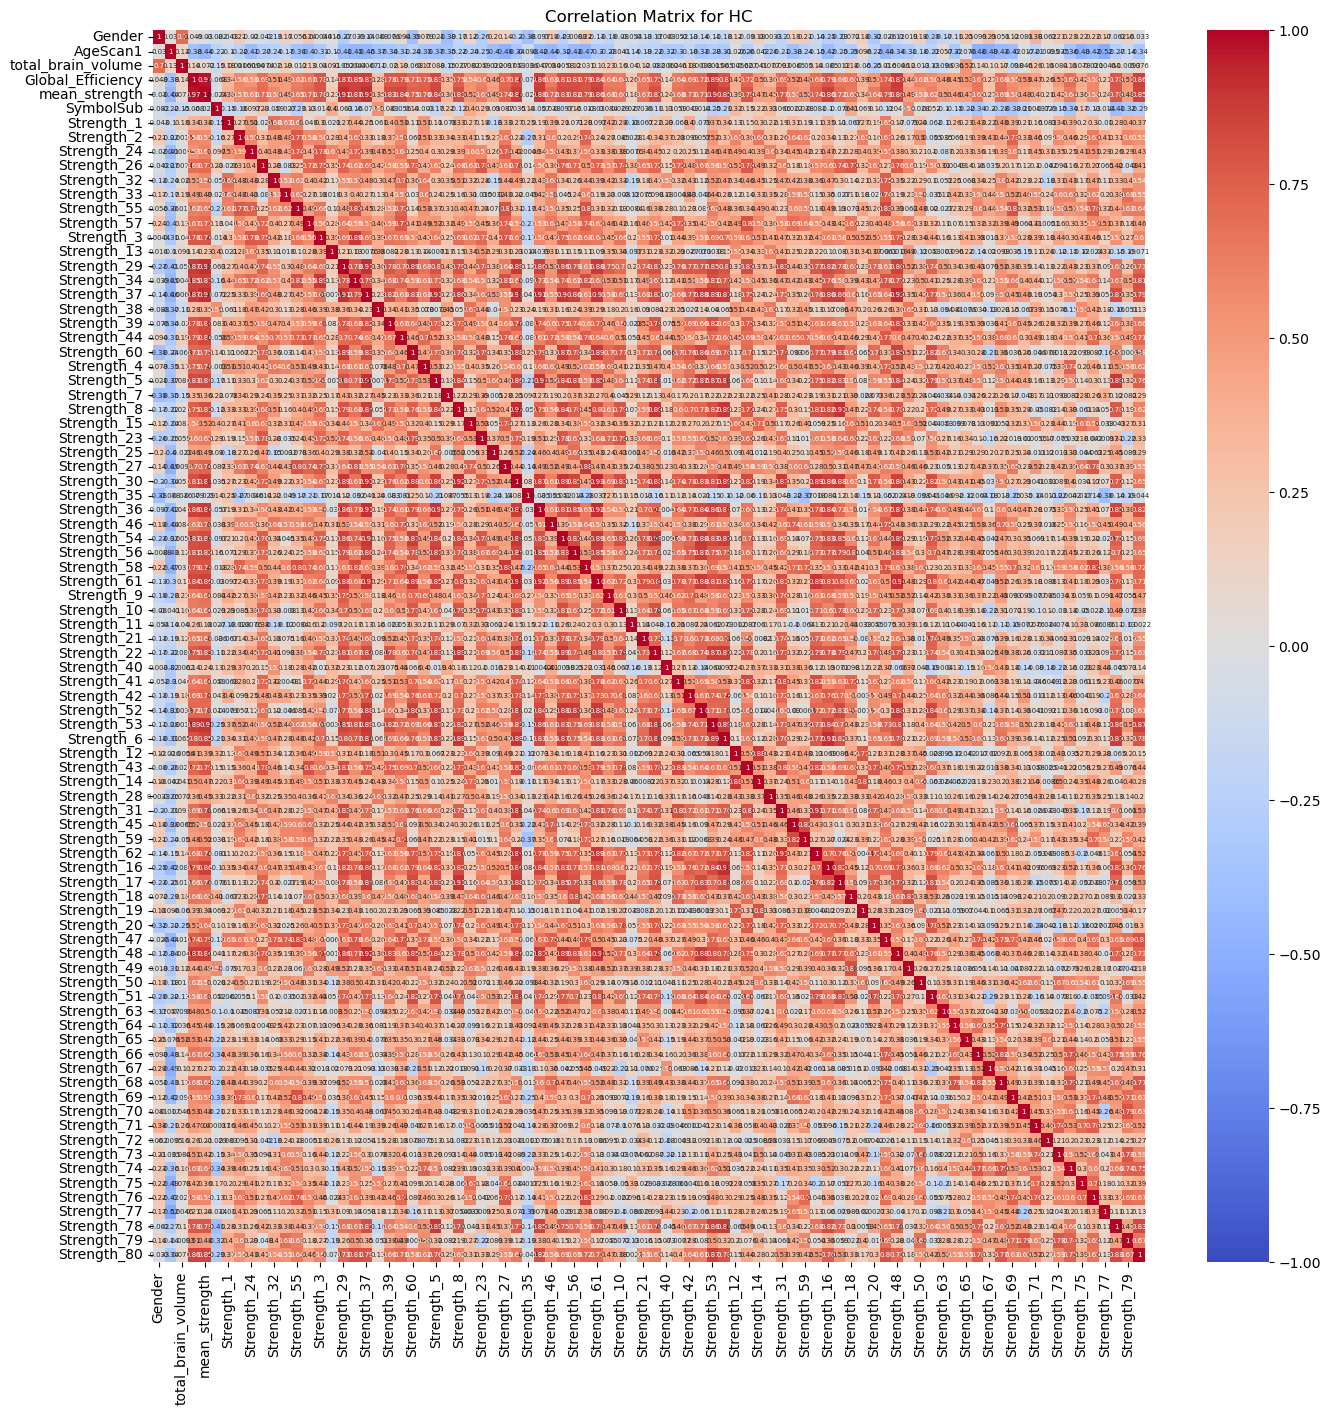

In [72]:
# Correlation matrix for HC #
df_HC = df[df['PatientCat'] == 'Healthy Control']

# Drop 'ID' and 'PatientCat' since no longer needed in correlation matrix calculation
df_HC_corr = df_HC.drop(df_HC.columns[0:2], axis = 1)

# Create the correlation matrix
corr_matrix_HC = df_HC_corr.corr()

# Visualization of the correlation matrix using heatmap
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix_HC, cmap = 'coolwarm', annot= True, vmin = -1, vmax = 1, annot_kws={"size": 5})
plt.title('Correlation Matrix for HC')
plt.show()

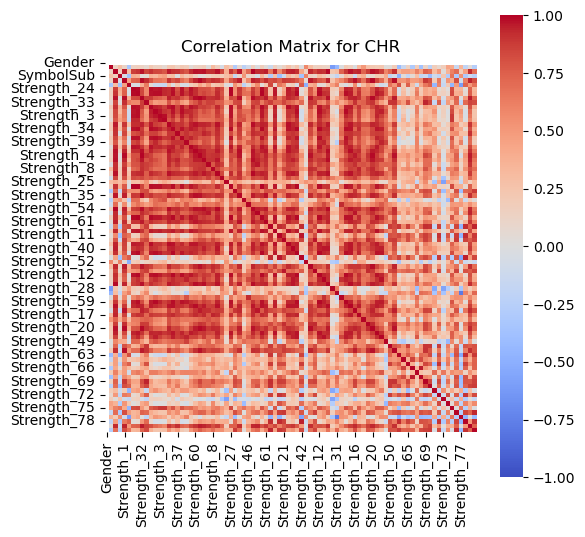

In [73]:
# Create the correlation matrix for CHR #
df_CHR = df[df['PatientCat'] == 'CHR']

# Drop 'ID' and 'PatientCat' since no longer needed in correlation matrix calculation
df_CHR_corr = df_CHR.drop(df_CHR.columns[0:2], axis = 1)
df_CHR_corr = df_CHR_corr.drop(df_HC.columns[4:6], axis = 1)

# Create the correlation matrix
corr_matrix_CHR = df_CHR_corr.corr()

# Visualization of the correlation matrix using heatmap
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix_CHR, cmap = 'coolwarm', vmin = -1, vmax = 1, square=True)
plt.title('Correlation Matrix for CHR')
plt.show()

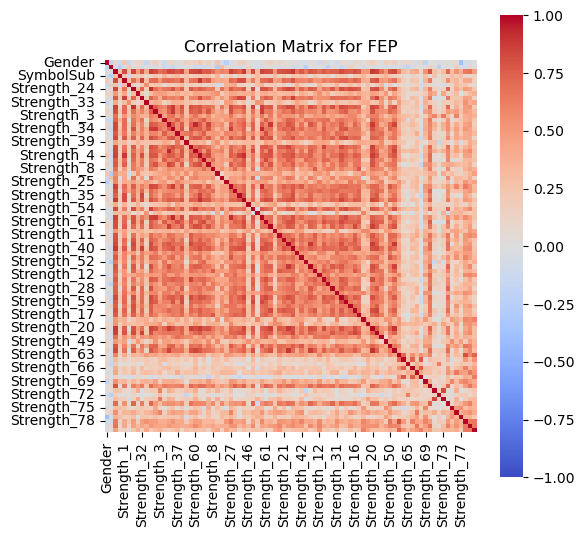

In [74]:
# Create the correlation matrix for FEP #
df_FEP = df[df['PatientCat'] == 'First Episode Patient']

# Drop 'ID' and 'PatientCat' since no longer needed in correlation matrix calculation
df_FEP_corr = df_FEP.drop(df_FEP.columns[0:2], axis = 1)
df_FEP_corr = df_FEP_corr.drop(df_HC.columns[4:6], axis = 1)

# Create the correlation matrix
corr_matrix_FEP = df_FEP_corr.corr()

# Visualization of the correlation matrix using heatmap
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix_FEP, cmap = 'coolwarm', vmin = -1, vmax = 1, square=True)
plt.title('Correlation Matrix for FEP')
plt.show()

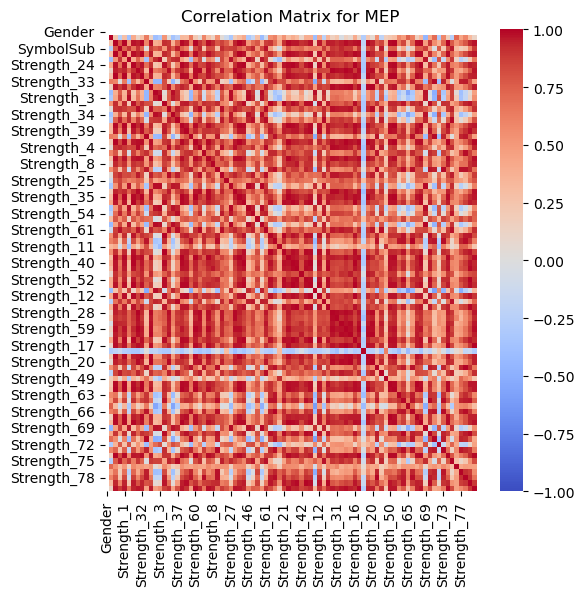

In [75]:
# Create the correlation matrix for MEP #
df_MEP = df[df['PatientCat'] == '3+ Year Patient']

# Drop 'ID' and 'PatientCat' since no longer needed in correlation matrix calculation
df_MEP_corr = df_MEP.drop(df_MEP.columns[0:2], axis = 1)
df_MEP_corr = df_MEP_corr.drop(df_HC.columns[4:6], axis = 1)

# Create the correlation matrix
corr_matrix_MEP = df_MEP_corr.corr()

# Visualization of the correlation matrix using heatmap
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix_MEP, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix for MEP')
plt.show()

In [76]:
# Function to apply Fisher's z transformation
def fisher_z(r):
    z = 0.5 * (np.log((1 + r) / (1 - r)))
    
    return z

# Function to compare two correlation matrices and compute p-values
def compare_correlation_matrices(corr1, corr2, n1, n2):
    z1 = fisher_z(corr1)
    z2 = fisher_z(corr2)
    
    se_diff = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = np.abs(z1 - z2) /se_diff
    
    p_values = 2 * (1 - stats.norm.cdf(z_stat)) # Two-tailed test
    
    return p_values

# Function to compute partical correlation using residualization
def partial_corr(x, y, covar_df):
    # Add constant for intercept
    covars = sm.add_constant(covar_df)

    # Regress x on covariates and get residuals
    model_x = sm.OLS(x, covars).fit()
    res_x = model_x.resid
    
    # Regress y on covariates and get residuals
    model_y = sm.OLS(y, covars).fit()
    res_y = model_y.resid
    
    return stats.pearsonr(res_x, res_y)[0]

# Compute a partial correlation matrix for all measures (excluding specified covariates)
def compute_partial_corr_matrix(df, covar_columns):
    
    # All columns that are not covariates are considered as measures
    measure_columns = [col for col in df.columns if col not in covar_columns]
    partial_corr_matrix = pd.DataFrame(index=measure_columns, columns=measure_columns)
    
    # Loop through each pair of measures to calculate the partial correlation
    for i in measure_columns:
        for j in measure_columns:
            if i == j:
                partial_corr_matrix.loc[i, j] = 1.0
            else:
                partial_corr_matrix.loc[i, j] = partial_corr(df[i], df[j], df[covar_columns])
    return partial_corr_matrix

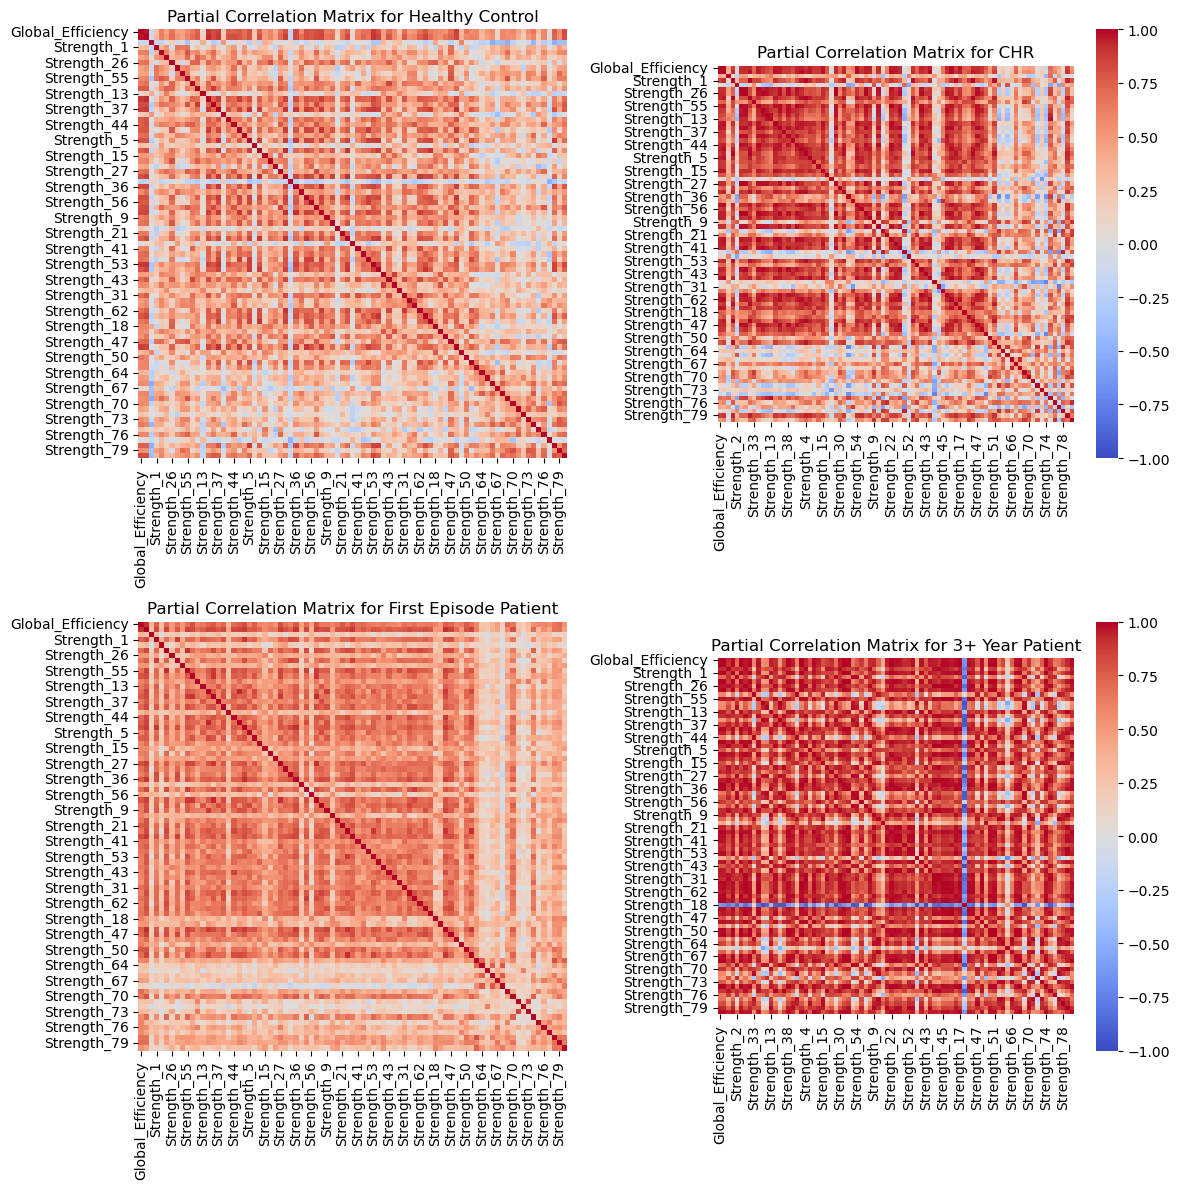

In [77]:
# Define the patient types and covariate columns
patient_types = ['Healthy Control', 'CHR', 'First Episode Patient', '3+ Year Patient']
covar_columns = ['AgeScan1', 'Gender', 'total_brain_volume']

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
partial_corr_matrices = {}  # Dictionary to store matrices for later comparisons

for i, patient_type in enumerate(patient_types):
    
    # Subset data for the current patient type
    df_data = df[df['PatientCat'] == patient_type]
    
    # Drop non-measure columns; adjust column names as needed (e.g. 'ID' and 'PatientCat')
    df_data = df_data.drop(columns=['ID', 'PatientCat'], axis = 1)
    
    # Compute the partial correlation matrix (controlling for age and gender)
    pcm = compute_partial_corr_matrix(df_data, covar_columns)
    partial_corr_matrices[patient_type] = pcm
    
    # Plot the heatmap of the partial correlation matrix
    sns.heatmap(pcm.astype(float), cmap='coolwarm', vmin=-1, vmax=1, 
                ax=axes[i//2, i%2], cbar=(i == 1 or i == 3), square=True)
    axes[i//2, i%2].set_title(f'Partial Correlation Matrix for {patient_type}')

plt.tight_layout()
plt.show()

In [88]:
from itertools import combinations

# Retrieve the matrices from your dictionary
groups = {
    "HC": partial_corr_matrices['Healthy Control'],
    "CHR": partial_corr_matrices['CHR'],
    "FEP": partial_corr_matrices['First Episode Patient'],
    "MEP": partial_corr_matrices['3+ Year Patient']
}

# Your Fisher z-transformation function with clipping to avoid division by zero
def fisher_z(r):
    r = np.asarray(r, dtype=float)
    r = np.clip(r, -0.9999, 0.9999)
    return 0.5 * np.log((1 + r) / (1 - r))

results = []

# Loop over all unique group pairs (6 comparisons total)
for (name1, mat1), (name2, mat2) in combinations(groups.items(), 2):
    # Check if mat1 is a DataFrame to extract row and column names
    if isinstance(mat1, pd.DataFrame):
        mat1_values = mat1.values
        row_labels = mat1.index.tolist()
        col_labels = mat1.columns.tolist()
    else:
        mat1_values = np.asarray(mat1, dtype=float)
        n = mat1_values.shape[0]
        row_labels = list(range(n))
        col_labels = list(range(n))
    
    # Do the same for mat2 (only need values)
    if isinstance(mat2, pd.DataFrame):
        mat2_values = mat2.values
    else:
        mat2_values = np.asarray(mat2, dtype=float)
    
    # Apply Fisher's transformation
    z1 = fisher_z(mat1_values)
    z2 = fisher_z(mat2_values)
    
    # Calculate the effect size matrix: difference of Fisher z-values
    effect_size_matrix = z1 - z2
    n = effect_size_matrix.shape[0]
    
    # Loop over the upper triangle to get each unique cell (excluding the diagonal)
    for i in range(n):
        for j in range(i+1, n):
            results.append({
                "Comparison": f"{name1} vs {name2}",
                "Row": row_labels[i],
                "Column": col_labels[j],
                "Effect_Size": effect_size_matrix[i, j]
            })

# Create a DataFrame from the results and save to CSV in the current folder
df_effect_sizes = pd.DataFrame(results)
df_effect_sizes.to_csv("/Users/siliangyan/Downloads/PYSC 380/aim_2_effect_size.csv", index=False)

print("CSV file 'aim_2_effect_size.csv' has been saved.")

CSV file 'aim_2_effect_size.csv' has been saved.


/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:3: RuntimeWarning: divide by zero encountered in divide
  z = 0.5 * (np.log((1 + r) / (1 - r)))
/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:13: RuntimeWarning: invalid value encountered in subtract
  z_stat = np.abs(z1 - z2) /se_diff
/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:3: RuntimeWarning: divide by zero encountered in divide
  z = 0.5 * (np.log((1 + r) / (1 - r)))
/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:13: RuntimeWarning: invalid value encountered in subtract
  z_stat = np.abs(z1 - z2) /se_diff
/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:3: RuntimeWarning: divide by zero encountered in divide
  z = 0.5 * (np.log((1 + r) / (1 - r)))
/var/folders/7w/rvr_pmy94m79xb0hr4jl3mvh0000gn/T/ipykernel_33153/1633313719.py:13: RuntimeWarning: invalid value encountered in s

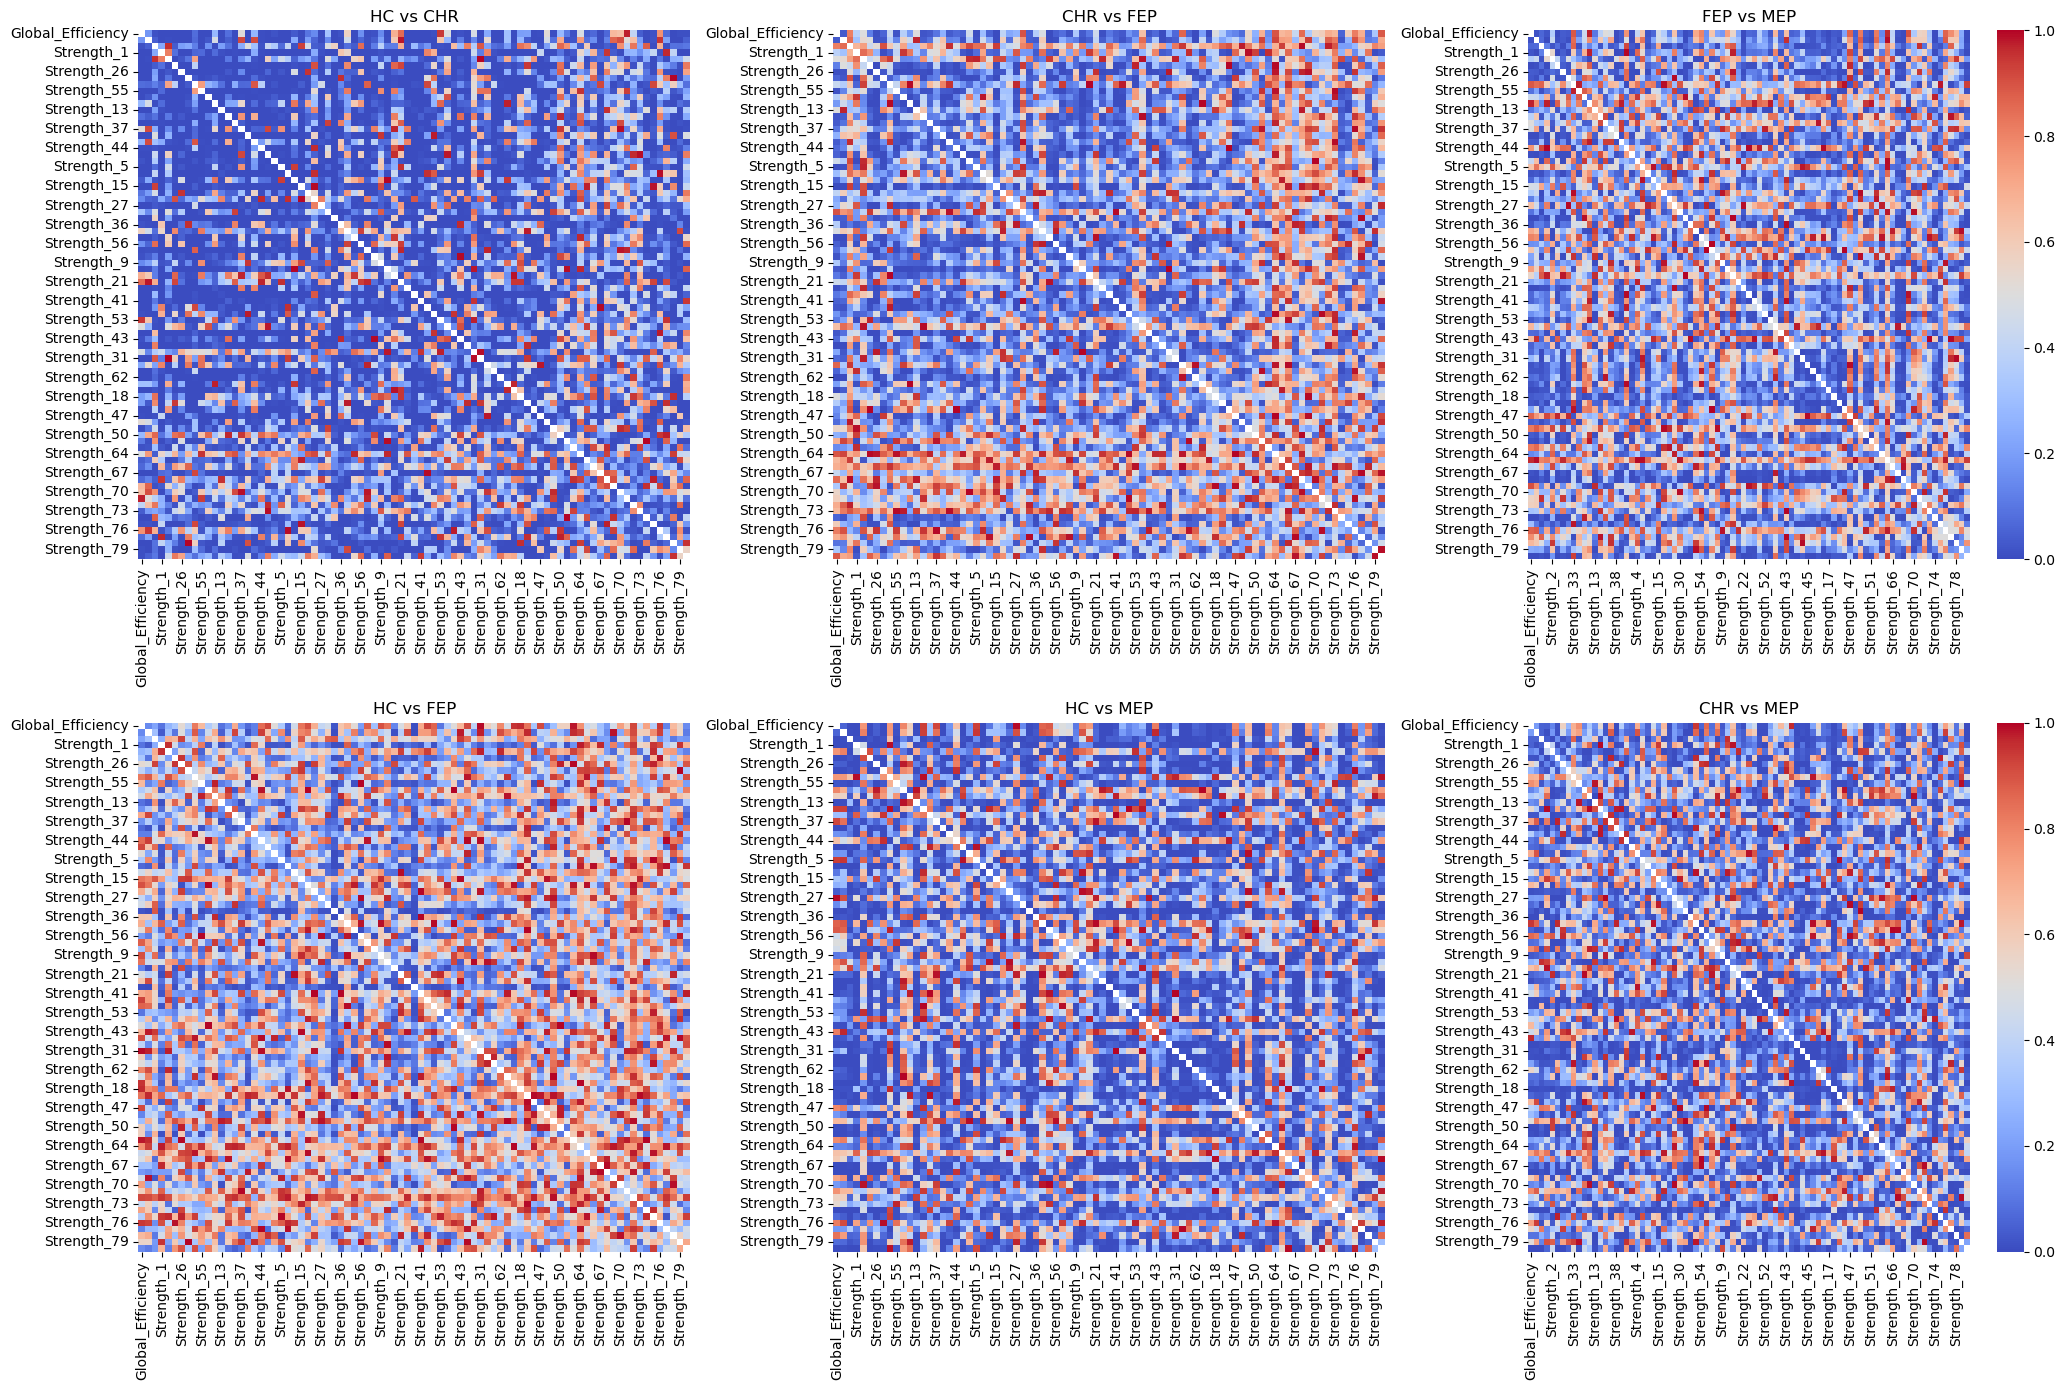

In [59]:
# Pairwise comparisons for the difference in correlation between groups

# Fill sample size for HC, CHR, FEP, MEP
n_HC, n_CHR, n_FEP, n_MEP = 53, 28, 10, 6

# Retrieve partial correlation matrices from the dictionary
pcm_HC  = partial_corr_matrices['Healthy Control']
pcm_CHR = partial_corr_matrices['CHR']
pcm_FEP = partial_corr_matrices['First Episode Patient']
pcm_MEP = partial_corr_matrices['3+ Year Patient']

# Compute p-value matrices for pairwise comparisons using Fisher's z
p_matrix_HC_CHR = compare_correlation_matrices(pcm_HC.astype(float).values, pcm_CHR.astype(float).values, n_HC, n_CHR)
p_matrix_CHR_FEP = compare_correlation_matrices(pcm_CHR.astype(float).values, pcm_FEP.astype(float).values, n_CHR, n_FEP)
p_matrix_FEP_MEP = compare_correlation_matrices(pcm_FEP.astype(float).values, pcm_MEP.astype(float).values, n_FEP, n_MEP)
# Additional comparisons
p_matrix_HC_FEP = compare_correlation_matrices(pcm_HC.astype(float).values, pcm_FEP.astype(float).values, n_HC, n_FEP)
p_matrix_HC_MEP = compare_correlation_matrices(pcm_HC.astype(float).values, pcm_MEP.astype(float).values, n_HC, n_MEP)
p_matrix_CHR_MEP = compare_correlation_matrices(pcm_CHR.astype(float).values, pcm_MEP.astype(float).values, n_CHR, n_MEP)

# Use the column names (assumed identical across matrices) for labels
labels = pcm_HC.columns

# Convert the numpy arrays to DataFrames
p_matrix_HC_CHR_df = pd.DataFrame(p_matrix_HC_CHR, index=labels, columns=labels)
p_matrix_CHR_FEP_df = pd.DataFrame(p_matrix_CHR_FEP, index=labels, columns=labels)
p_matrix_FEP_MEP_df = pd.DataFrame(p_matrix_FEP_MEP, index=labels, columns=labels)
# Additional comparisons
p_matrix_HC_FEP_df = pd.DataFrame(p_matrix_HC_FEP, index=labels, columns=labels)
p_matrix_HC_MEP_df = pd.DataFrame(p_matrix_HC_MEP, index=labels, columns=labels)
p_matrix_CHR_MEP_df = pd.DataFrame(p_matrix_CHR_MEP, index=labels, columns=labels)

# Optionally, save the p-value matrices to CSV files
p_matrix_HC_CHR_df.to_csv('p_matrix_HC_CHR.csv')
p_matrix_CHR_FEP_df.to_csv('p_matrix_CHR_FEP.csv')
p_matrix_FEP_MEP_df.to_csv('p_matrix_FEP_MEP.csv')
p_matrix_HC_FEP_df.to_csv('p_matrix_HC_FEP.csv')

# Plot the p-value matrices in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(21, 14))
p_matrices = [p_matrix_HC_CHR_df, p_matrix_CHR_FEP_df, p_matrix_FEP_MEP_df,
              p_matrix_HC_FEP_df, p_matrix_HC_MEP_df, p_matrix_CHR_MEP_df]
titles = ['HC vs CHR', 'CHR vs FEP', 'FEP vs MEP', 'HC vs FEP', 'HC vs MEP', 'CHR vs MEP']

axes = axes.flatten()
for i, p_matrix in enumerate(p_matrices):
    sns.heatmap(p_matrix, cmap='coolwarm', vmin=0, vmax=1, ax=axes[i], cbar=(i == 2 or i == 5))
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

In [60]:

index_number = df.columns.get_loc("Strength_57")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_60")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_61")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_53")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_62")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_63")
print("The index number of column 'x' is:", index_number)
index_number = df.columns.get_loc("Strength_80")
print("The index number of column 'x' is:", index_number)

The index number of column 'x' is: 15
The index number of column 'x' is: 24
The index number of column 'x' is: 40
The index number of column 'x' is: 50
The index number of column 'x' is: 59
The index number of column 'x' is: 70
The index number of column 'x' is: 87


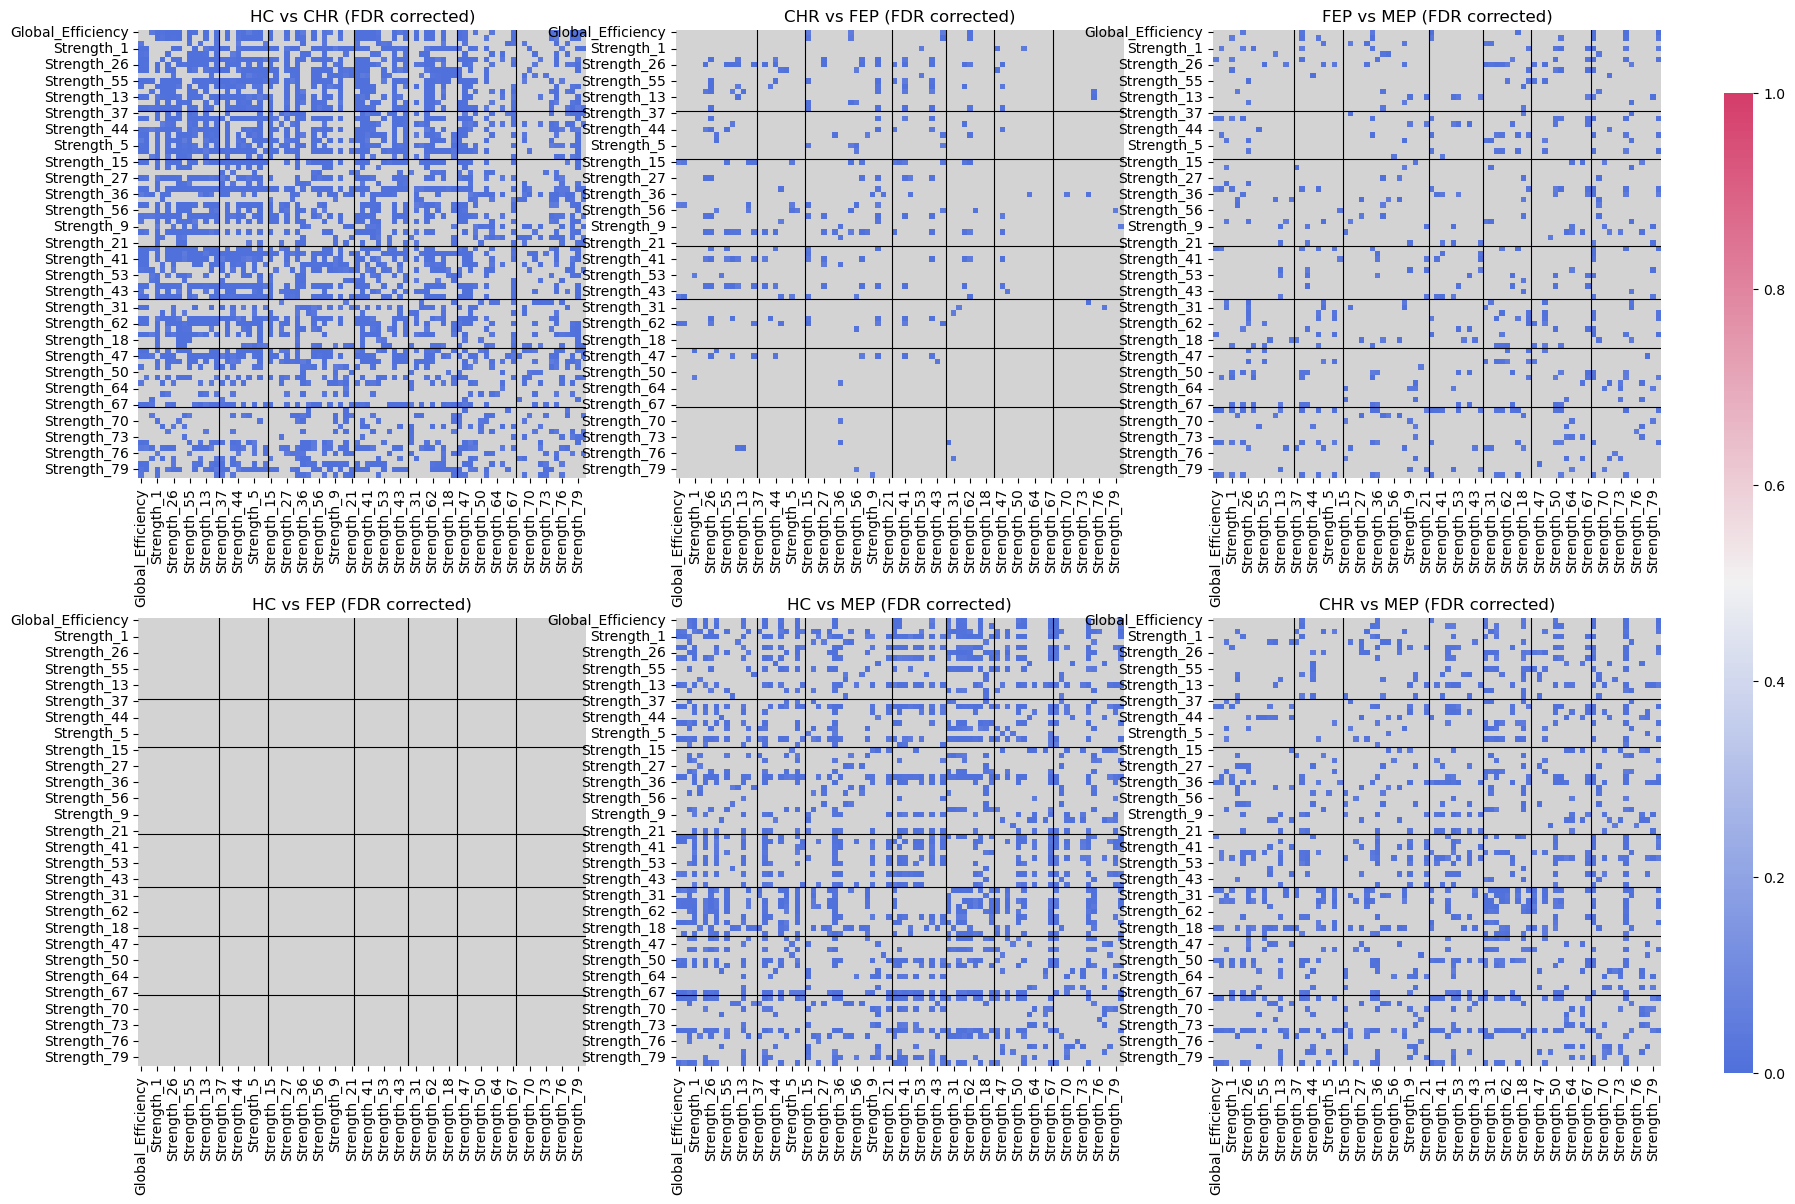

In [61]:
# Apply FDR correction for the result pairwise comparisons #
# Function for false discovery rate correction in the pair-wise comparison
def apply_fdr_ignore_nan(p_matrix_df, alpha=0.05):
    # Create a boolean mask of non-NaN entries
    mask = ~p_matrix_df.isna()
    
    # Extract the non-NaN p-values as a 1D array
    p_values = p_matrix_df.values[mask.values]
    
    # Apply FDR correction using the Benjamini-Hochberg method
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    
    # Get a copy of the original array and assign the corrected p-values in the positions defined by the mask
    corrected_array = p_matrix_df.values.copy()
    corrected_array[mask.values] = pvals_corrected
    
    # Convert back to DataFrame with the same index and columns
    return pd.DataFrame(corrected_array, index=p_matrix_df.index, columns=p_matrix_df.columns)

# Apply FDR correction to each of the p-value matrices
p_matrix_HC_CHR_fdr = apply_fdr_ignore_nan(p_matrix_HC_CHR_df)
p_matrix_CHR_FEP_fdr = apply_fdr_ignore_nan(p_matrix_CHR_FEP_df)
p_matrix_FEP_MEP_fdr = apply_fdr_ignore_nan(p_matrix_FEP_MEP_df)

p_matrix_HC_FEP_fdr = apply_fdr_ignore_nan(p_matrix_HC_FEP_df)
p_matrix_HC_MEP_fdr = apply_fdr_ignore_nan(p_matrix_HC_MEP_df)
p_matrix_CHR_MEP_fdr = apply_fdr_ignore_nan(p_matrix_CHR_MEP_df)

p_matrix_HC_FEP_fdr.to_csv('p_matrix_HC_FEP_fdr.csv')

# Function to replace cells with values above 0.05 with NaN (so they will appear gray)
def grey_out_above_0_05(p_matrix):
    p_matrix_copy = p_matrix.copy()
    p_matrix_copy[p_matrix_copy >= 0.05] = float('nan')  # Replace values > 0.05 with NaN
    return p_matrix_copy

# Apply the grey-out function to each of the corrected p-value matrices
p_matrix_HC_CHR_fdr_greyed = grey_out_above_0_05(p_matrix_HC_CHR_fdr)
p_matrix_CHR_FEP_fdr_greyed = grey_out_above_0_05(p_matrix_CHR_FEP_fdr)
p_matrix_FEP_MEP_fdr_greyed = grey_out_above_0_05(p_matrix_FEP_MEP_fdr)

p_matrix_HC_FEP_fdr_greyed = grey_out_above_0_05(p_matrix_HC_FEP_fdr)
p_matrix_HC_MEP_fdr_greyed = grey_out_above_0_05(p_matrix_HC_MEP_fdr)
p_matrix_CHR_MEP_fdr_greyed = grey_out_above_0_05(p_matrix_CHR_MEP_fdr)

# Plot the FDR corrected matrices together in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(21, 14))
titles = ['HC vs CHR (FDR corrected)', 'CHR vs FEP (FDR corrected)', 'FEP vs MEP (FDR corrected)',
          'HC vs FEP (FDR corrected)', 'HC vs MEP (FDR corrected)', 'CHR vs MEP (FDR corrected)']
axes = axes.flatten()

# Create a custom colormap and set its "bad" (NaN) color to gray
cmap = sns.diverging_palette(260, 0, as_cmap=True)
cmap.set_bad(color='#D3D3D3')

# Define  network boundaries
boundaries = [15, 24, 40, 50, 59, 70, 87]

# Adjust the figure to reserve space for a shared colorbar on the right
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.12, 0.014, 0.7])

# Plot the first heatmap with the shared colorbar; the others without individual colorbars
im = sns.heatmap(p_matrix_HC_CHR_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[0],
                 cbar=True, cbar_ax=cbar_ax, square=True)
axes[0].set_title(titles[0])

sns.heatmap(p_matrix_CHR_FEP_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[1],
            cbar=False, square=True)
axes[1].set_title(titles[1])

sns.heatmap(p_matrix_FEP_MEP_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[2],
            cbar=False, square=True)
axes[2].set_title(titles[2])

# Additional analysis
sns.heatmap(p_matrix_HC_FEP_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[3],
                 cbar=False, square=True)
axes[3].set_title(titles[3])

sns.heatmap(p_matrix_HC_MEP_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[4],
            cbar=False, square=True)
axes[4].set_title(titles[4])

sns.heatmap(p_matrix_CHR_MEP_fdr_greyed, cmap=cmap, vmin=0, vmax=1, ax=axes[5],
            cbar=False, square=True)
axes[5].set_title(titles[5])

# Add horizontal and vertical segregation lines at each network boundary for every subplot
for ax in axes:
    for boundary in boundaries:
        ax.axhline(boundary, color='black', linewidth=0.8)
        ax.axvline(boundary, color='black', linewidth=0.8)

plt.show()

In [62]:
# Extract unique entries with parameter labels
# Create a mask for the upper triangle (excluding the diagonal)
mask = np.triu(np.ones(p_matrix_HC_CHR_fdr.shape, dtype=bool), k=1)

# HC vs CHR
df_HC_CHR = p_matrix_HC_CHR_fdr.where(mask).stack().reset_index()
df_HC_CHR.columns = ['param1', 'param2', 'HC_vs_CHR']

# CHR vs FEP
df_CHR_FEP = p_matrix_CHR_FEP_fdr.where(mask).stack().reset_index()
df_CHR_FEP.columns = ['param1', 'param2', 'CHR_vs_FEP']

# FEP vs MEP
df_FEP_MEP = p_matrix_FEP_MEP_fdr.where(mask).stack().reset_index()
df_FEP_MEP.columns = ['param1', 'param2', 'FEP_vs_MEP']

# HC vs FEP
df_HC_FEP = p_matrix_HC_FEP_fdr.where(mask).stack().reset_index()
df_HC_FEP.columns = ['param1', 'param2', 'HC_vs_FEP']

# HC vs MEP
df_HC_MEP = p_matrix_HC_MEP_fdr.where(mask).stack().reset_index()
df_HC_MEP.columns = ['param1', 'param2', 'HC_vs_MEP']

# CHR vs MEP
df_CHR_MEP = p_matrix_CHR_MEP_fdr.where(mask).stack().reset_index()
df_CHR_MEP.columns = ['param1', 'param2', 'CHR_vs_MEP']

# Merge the six comparisons
# Since all matrices use the same parameters and orders, merge on 'param1' and 'param2'
df_merged = df_HC_CHR.merge(df_CHR_FEP, on=['param1', 'param2'])\
                     .merge(df_FEP_MEP, on=['param1', 'param2'])\
                     .merge(df_HC_FEP,  on=['param1', 'param2'])\
                     .merge(df_HC_MEP,  on=['param1', 'param2'])\
                     .merge(df_CHR_MEP,  on=['param1', 'param2'])\

# Create the "comparisons" column that indicates parameters compared
df_merged['comparisons'] = df_merged['param1'] + " vs " + df_merged['param2']

# Rearrange columns so that 'comparisons' appears first
df_final = df_merged[['comparisons', 'HC_vs_CHR', 'CHR_vs_FEP', 'FEP_vs_MEP', 'HC_vs_FEP', 'HC_vs_MEP', 'CHR_vs_MEP']]

# Write to csv
df_final.to_csv('/Users/siliangyan/Downloads/PYSC 380/fdr_corrected_p_values.csv', index=False)

In [63]:
# Create a new DataFrame by filtering rows where 'measure' contains 'SymbolSub'
df_symbol = df_final[df_final['comparisons'].str.contains("SymbolSub", na=False)]

# Optionally, display the first few rows of the filtered DataFrame
print(df_symbol)

                        comparisons  HC_vs_CHR  CHR_vs_FEP  FEP_vs_MEP  \
1    Global_Efficiency vs SymbolSub   0.035683    0.930000    0.258373   
82       mean_strength vs SymbolSub   0.096532    0.948718    0.269427   
163         SymbolSub vs Strength_1   0.349292    0.868651    0.367843   
164         SymbolSub vs Strength_2   0.969830    0.901491    0.111358   
165        SymbolSub vs Strength_24   0.082604    0.717010    0.299783   
..                              ...        ...         ...         ...   
238        SymbolSub vs Strength_76   0.777561    0.595947    0.367720   
239        SymbolSub vs Strength_77   0.016630    0.806023    0.943118   
240        SymbolSub vs Strength_78   0.162720    0.823837    0.752339   
241        SymbolSub vs Strength_79   0.159762    0.929030    0.537597   
242        SymbolSub vs Strength_80   0.177001    0.901491    0.111206   

     HC_vs_FEP  HC_vs_MEP  CHR_vs_MEP  
1     0.899785   0.016402    0.173773  
82    0.934547   0.026108    0.

In [64]:
df_symbol_sub = df_symbol.iloc[2:]
df_symbol_sub

,comparisons,HC_vs_CHR,CHR_vs_FEP,FEP_vs_MEP,HC_vs_FEP,HC_vs_MEP,CHR_vs_MEP
163,SymbolSub vs Strength_1,0.349292,0.868651,0.367843,0.921119,0.041309,0.147343
164,SymbolSub vs Strength_2,0.969830,0.901491,0.111358,0.976289,0.014198,0.025107
165,SymbolSub vs Strength_24,0.082604,0.717010,0.299783,0.976289,0.073926,0.341217
166,SymbolSub vs Strength_26,0.313924,0.778053,0.071136,0.996516,0.010499,0.057444
167,SymbolSub vs Strength_32,0.346025,0.969582,0.363397,0.945769,0.060893,0.192009
...,...,...,...,...,...,...,...
238,SymbolSub vs Strength_76,0.777561,0.595947,0.367720,0.867611,0.029277,0.063874
239,SymbolSub vs Strength_77,0.016630,0.806023,0.943118,0.929556,0.556738,0.906387
240,SymbolSub vs Strength_78,0.162720,0.823837,0.752339,0.832795,0.161776,0.455691
241,SymbolSub vs Strength_79,0.159762,0.929030,0.537597,0.874449,0.082859,0.305539


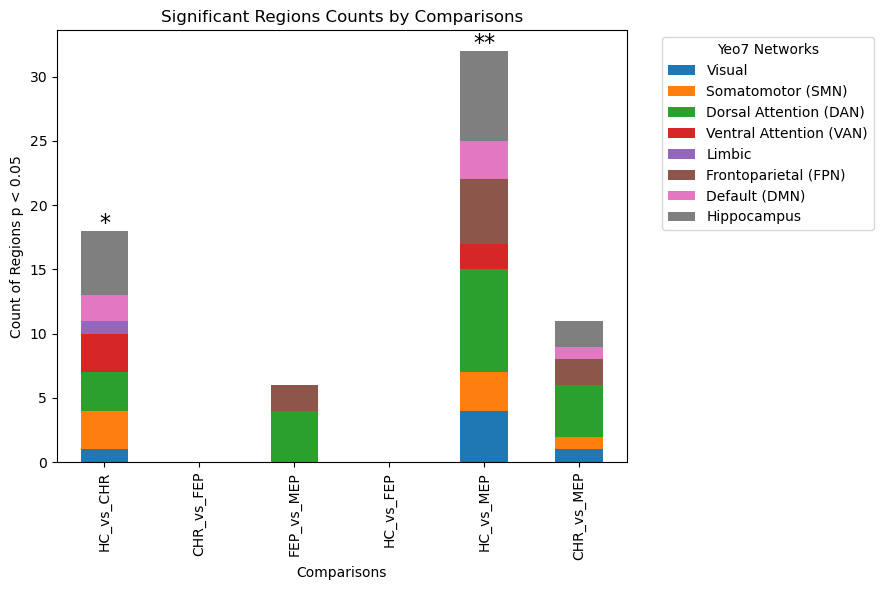

In [65]:
# Reset index to ensure we can use iloc
df_symbol_sub = df_symbol_sub.reset_index(drop=True)

# Choose the column containing the segmentation markers
segmentation_col = "comparisons" 

# Define segmentation markers
segmentation_markers = ["Strength_57", "Strength_60", "Strength_61", "Strength_53", "Strength_43", "Strength_62", "Strength_51"]

# Find the indices where the segmentation markers are present
marker_mask = df_symbol_sub[segmentation_col].str.contains('|'.join(segmentation_markers), na = False)
marker_indices = df_symbol_sub.index[marker_mask].tolist()

# Sort marker indices to ensure correct order
marker_indices.sort()

# Define Segments (end inclusive)
segments = []
segment_labels = []

prev_idx = 0
for marker_idx in marker_indices:
    # Include the marker row by slicing to marker_idx + 1
    label = "Up to " + str(df_symbol_sub.loc[marker_idx, segmentation_col])
    segments.append(df_symbol_sub.iloc[prev_idx: marker_idx + 1])
    segment_labels.append(label)
    prev_idx = marker_idx + 1

# Final segment: from the row after the last marker to the end, if any rows remain
if prev_idx < len(df_symbol_sub):
    label = "After " + str(df_symbol_sub.loc[marker_indices[-1], segmentation_col])
    segments.append(df_symbol_sub.iloc[prev_idx:])
    segment_labels.append(label)

# Count significant cells for each segment
# Use every column except the segmentation column as a bar in the stacked chart
data_columns = [col for col in df_symbol_sub.columns if col != segmentation_col]

# Initialize a DataFrame for counts with data_columns as index and segment_labels as columns
counts = pd.DataFrame(index=data_columns, columns=segment_labels)

for col in data_columns:
    for seg_label, seg_df in zip(segment_labels, segments):
        # Count the number of cells in column 'col' with a value < 0.05 within this segment
        count_val = (seg_df[col] < 0.05).sum()
        counts.loc[col, seg_label] = count_val

# Convert counts to integer type
counts = counts.astype(int)

# Assign Yeo7 network labels
yeo7_labels = [
    "Visual",
    "Somatomotor (SMN)",
    "Dorsal Attention (DAN)",
    "Ventral Attention (VAN)",
    "Limbic",
    "Frontoparietal (FPN)",
    "Default (DMN)",
    "Hippocampus"
]

# Rename segment columns using Yeo7 labels
counts.columns = yeo7_labels

# --- Plot as Stacked Bar Chart with Yeo7 Labels ---
ax = counts.plot(kind="bar", stacked=True, figsize=(9, 6))
ax.set_xlabel("Comparisons")
ax.set_ylabel("Count of Regions p < 0.05")
ax.set_title("Significant Regions Counts by Comparisons")
plt.legend(title="Yeo7 Networks", bbox_to_anchor=(1.05, 1), loc="upper left")

# Makr specific bars where there is significant difference in global efficiency or mean strength
bars_to_mark = {
    'HC_vs_CHR': '*',
    'HC_vs_MEP': '**'
}

# Annotate each specified bar
for bar_name, asterisk in bars_to_mark.items():
    bar_height = counts.loc[bar_name].sum()
    bar_idx = counts.index.get_loc(bar_name)

    ax.annotate(asterisk,
                xy=(bar_idx, bar_height),
                xytext=(0, 0.5),  # Offset upwards by 8 points
                textcoords='offset points',
                ha='center',
                fontsize=16,
                color='black')

plt.tight_layout()
plt.show()

In [67]:
# Summarize counts and percentages
summary = counts.copy()

# Add a 'Total' column to get the total number of significant measures per bar
summary['Total'] = summary.sum(axis=1)

# Compute percentages for each network within each bar
percentage = summary.div(summary['Total'], axis=0) * 100
percentage = percentage.round(2)

# Combine counts and percentages in a neat table for readability
final_summary = pd.DataFrame(index=summary.index)

for network in counts.columns:
    final_summary[f"{network} (count)"] = counts[network]
    final_summary[f"{network} (%)"] = percentage[network]

final_summary['Total (count)'] = summary['Total']

# Display the final summary table
print("\nSummary Table: Count and Percentage of Strength Measures per Network\n")
print(final_summary)
final_summary.to_excel('/Users/siliangyan/Downloads/PYSC 380/aim_2_summary.xlsx')


Summary Table: Count and Percentage of Strength Measures per Network

            Visual (count)  Visual (%)  Somatomotor (SMN) (count)  \
HC_vs_CHR                1        5.56                          3   
CHR_vs_FEP               0         NaN                          0   
FEP_vs_MEP               0        0.00                          0   
HC_vs_FEP                0         NaN                          0   
HC_vs_MEP                4       12.50                          3   
CHR_vs_MEP               1        9.09                          1   

            Somatomotor (SMN) (%)  Dorsal Attention (DAN) (count)  \
HC_vs_CHR                   16.67                               3   
CHR_vs_FEP                    NaN                               0   
FEP_vs_MEP                   0.00                               4   
HC_vs_FEP                     NaN                               0   
HC_vs_MEP                    9.38                               8   
CHR_vs_MEP                   9.

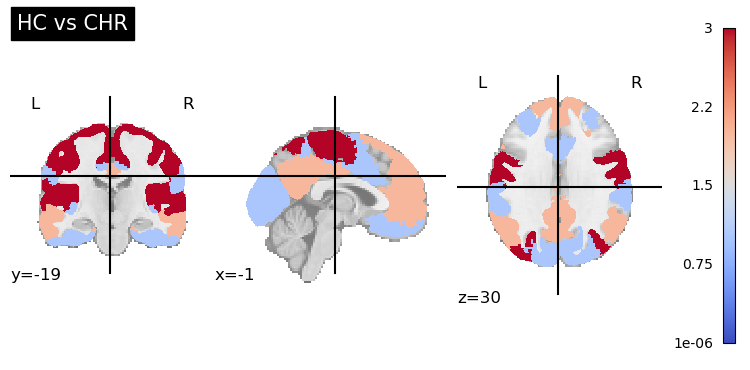

In [41]:
# 1) Define your row data for the 7 Yeo networks
row_data = {
    1: 1,  # Visual
    2: 3,  # SomatoMotor
    3: 3,  # Dorsal Attention
    4: 1,  # Ventral Attention
    5: 1,  # Limbic
    6: 0,  # Frontoparietal
    7: 2   # Default Mode
}

# 2) Fetch the Yeo 7 atlas (thick version)
yeo = fetch_atlas_yeo_2011(verbose=1)
atlas_file = yeo['thick_7']  # This is a file path (string)

# Load the NIfTI image from the file path
atlas_img = nib.load(atlas_file)

# 3) Map the row_data values to each network label
atlas_data = atlas_img.get_fdata()
mapped_data = np.zeros_like(atlas_data, dtype=np.float32)

for label_number, value in row_data.items():
    mapped_data[atlas_data == label_number] = value

mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, atlas_img.header)

# 4) Plot the resulting image
plot_stat_map(
    mapped_img,
    display_mode='ortho',
    title = 'HC vs CHR',
    dim=0.6,
    cmap='coolwarm'
)

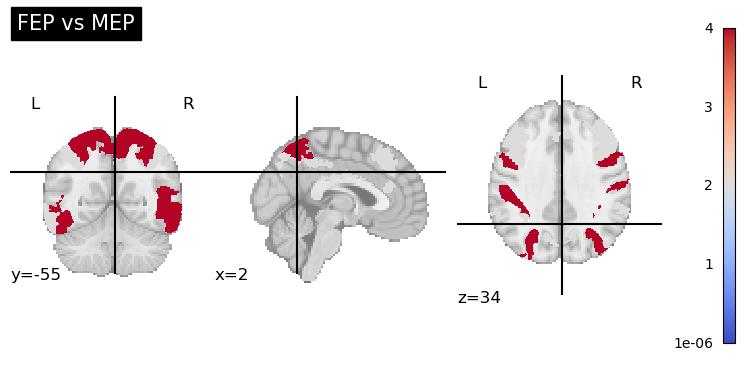

In [54]:
# 1) Define your row data for the 7 Yeo networks
row_data = {
    1: 0,  # Visual
    2: 0,  # SomatoMotor
    3: 4,  # Dorsal Attention
    4: 0,  # Ventral Attention
    5: 0,  # Limbic
    6: 2,  # Frontoparietal
    7: 0   # Default Mode
}

# 2) Fetch the Yeo 7 atlas (thick version)
yeo = fetch_atlas_yeo_2011(verbose=1)
atlas_file = yeo['thick_7']  # This is a file path (string)

# Load the NIfTI image from the file path
atlas_img = nib.load(atlas_file)

# 3) Map the row_data values to each network label
atlas_data = atlas_img.get_fdata()
mapped_data = np.zeros_like(atlas_data, dtype=np.float32)

for label_number, value in row_data.items():
    mapped_data[atlas_data == label_number] = value

mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, atlas_img.header)

# 4) Plot the resulting image
plot_stat_map(
    mapped_img,
    display_mode='ortho',
    title = 'FEP vs MEP',
    dim=0.6,
    cmap='coolwarm'
)

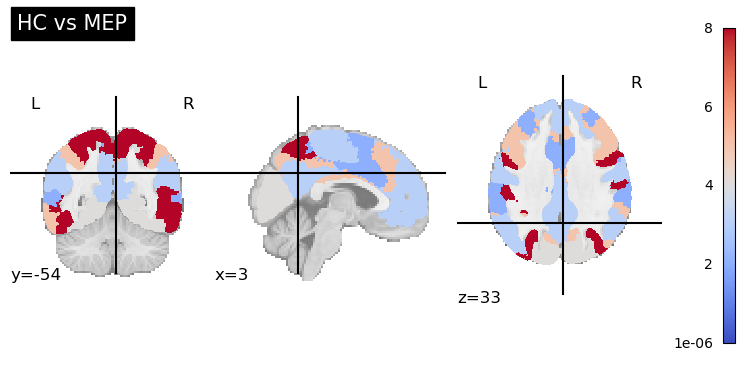

In [48]:
# 1) Define your row data for the 7 Yeo networks
row_data = {
    1: 4,  # Visual
    2: 3,  # SomatoMotor
    3: 8,  # Dorsal Attention
    4: 2,  # Ventral Attention
    5: 0,  # Limbic
    6: 5,  # Frontoparietal
    7: 3   # Default Mode
}

# 2) Fetch the Yeo 7 atlas (thick version)
yeo = fetch_atlas_yeo_2011(verbose=1)
atlas_file = yeo['thick_7']  # This is a file path (string)

# Load the NIfTI image from the file path
atlas_img = nib.load(atlas_file)

# 3) Map the row_data values to each network label
atlas_data = atlas_img.get_fdata()
mapped_data = np.zeros_like(atlas_data, dtype=np.float32)

for label_number, value in row_data.items():
    mapped_data[atlas_data == label_number] = value

mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, atlas_img.header)

# 4) Plot the resulting image
plot_stat_map(
    mapped_img,
    display_mode='ortho',
    title = 'HC vs MEP',
    dim=0.6,
    cmap='coolwarm'
)

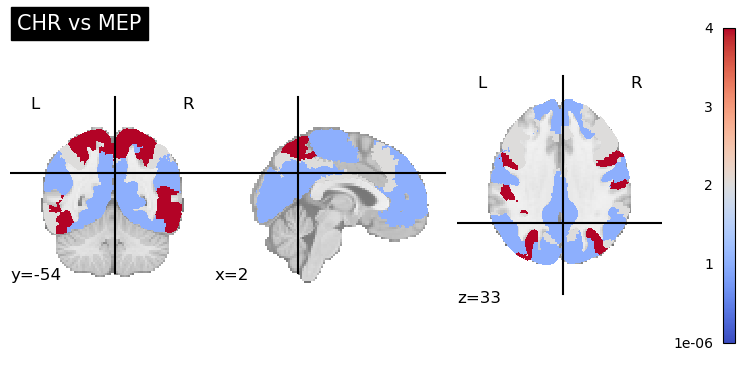

In [45]:
# 1) Define your row data for the 7 Yeo networks
row_data = {
    1: 1,  # Visual
    2: 1,  # SomatoMotor
    3: 4,  # Dorsal Attention
    4: 0,  # Ventral Attention
    5: 0,  # Limbic
    6: 2,  # Frontoparietal
    7: 1   # Default Mode
}

# 2) Fetch the Yeo 7 atlas (thick version)
yeo = fetch_atlas_yeo_2011(verbose=1)
atlas_file = yeo['thick_7']  # This is a file path (string)

# Load the NIfTI image from the file path
atlas_img = nib.load(atlas_file)

# 3) Map the row_data values to each network label
atlas_data = atlas_img.get_fdata()
mapped_data = np.zeros_like(atlas_data, dtype=np.float32)

for label_number, value in row_data.items():
    mapped_data[atlas_data == label_number] = value

mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, atlas_img.header)

# 4) Plot the resulting image
plot_stat_map(
    mapped_img,
    display_mode='ortho',
    title = 'CHR vs MEP',
    dim=0.6,
    cmap='coolwarm'
)

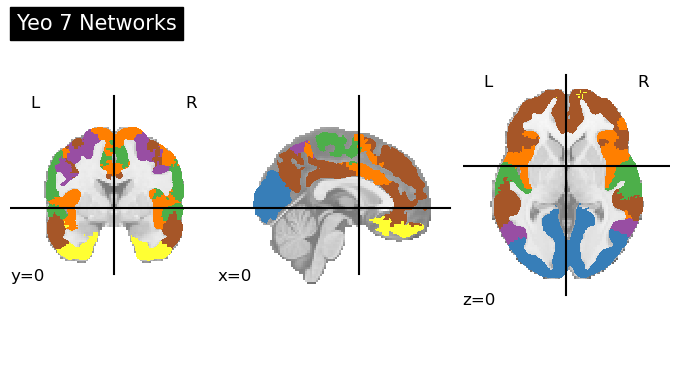

In [53]:

# 1) Fetch the Yeo 7 atlas (thick version) and load the image
yeo = fetch_atlas_yeo_2011(verbose=1)
atlas_file = yeo['thick_7']  # this is a file path
atlas_img = nib.load(atlas_file)

# 2) Create a discrete colormap with 7 colors (one for each network)
colors = ['#e41a1c',  # red for Visual
          '#377eb8',  # blue for SomatoMotor
          '#4daf4a',  # green for Dorsal Attention
          '#984ea3',  # purple for Ventral Attention
          '#ff7f00',  # orange for Limbic
          '#ffff33',  # yellow for Frontoparietal
          '#a65628']  # brown for Default Mode
cmap = ListedColormap(colors)

# 3) Plot the atlas with the discrete colormap
display = plot_stat_map(
    atlas_img,
    display_mode='ortho',
    title='Yeo 7 Networks',
    cmap=cmap,
    cut_coords=(0, 0, 0),
    colorbar=False
)